In [1]:
import numpy as np
from sympy import *
from sympy.physics.mechanics import *
from sympy.tensor.array import Array
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
np.set_printoptions(precision=4)
init_printing()

In [2]:
class kinematics():

    def __init__(self, nDoF=3, robot='3DoF'):
        self.nDoF = nDoF
        self.qm, self.qdm, self.l, self.r = self.initializing(self.nDoF)  # qm = manipulator joint angles
        # qdm = manipulator joint velocities, l = link lengths, r = COM vectors from joints

        if robot == '3DoF':  # as given in umeneti and yoshida: resolved motion rate control of space manipulators
            self.l_num = np.array([3.5, 0.25, 2.5, 2.5])
            self.ang_s0 = Array([0., 0., 0.])
            self.r_s0 = Array([0.01, 0.01, 0.0])
            self.q0 = Array([pi / 3 * 0, 5*pi / 4, pi/2])  # as given in Umaneti and Yoshida: Resolved..
            # self.q0 = Array([pi / 3 * 0, pi / 2, 0])
            # DH parameters:
            self.alpha = Array([-pi / 2, pi / 2, 0.])
            self.a = Array([0., 0., 2.5])
            self.d = Array([0.25, 0., 0.])
            self.eef_dist = 2.50  # l3
        else:
            self.a = Array([0, *self.l])
            self.d = Array([0.0, 0.0])
            self.alpha = Array([0.0, 0.0])
        hh = 2.1
        self.size = [(hh, hh, hh)]  # satellite dimension
        x, y, z = 0.5*self.size[0][0], 0.5*self.size[0][0], 0
        self.b0 = np.array([x, y, 0.])  # vector from spacecraft COM to robot base wrt spacecraft CS

        self.r_sx, self.r_sy, self.r_sz, = dynamicsymbols('r_sx r_sy r_sz')  # r_s = satellite pos_vec wrt inertial
        self.ang_xs, self.ang_ys, self.ang_zs = dynamicsymbols("ang_xs ang_ys ang_zs ")
        self.r_sxd, self.r_syd, self.r_szd, = dynamicsymbols('r_sx r_sy r_sz', 1)  # satellite linear vel wrt inertial
        self.w_sxd, self.w_syd, self.w_szd = dynamicsymbols("ang_xs ang_ys ang_zs ",
                                                            1)  # satellite angular vel wrt inertial
        self.q = Matrix([self.r_sx, self.r_sy, self.r_sz, self.ang_xs, self.ang_ys, self.ang_zs, *self.qm])
        self.qd = Matrix([self.r_sxd, self.r_syd, self.r_szd, self.w_sxd, self.w_syd, self.w_szd, *self.qdm])

        self.rx = symbols(["r%d" % x for x in range(1, nDoF+1)])  # x component of COM vector of the links
        self.aa = symbols(["aa%d" % x for x in range(1, nDoF+1)])  # x component of vector from joint i to COM of link i
        self.bb = symbols(["bb%d" % x for x in range(nDoF)])  # x component of vector frm COM of link i to joint i+1

        self.q_i, self.alpha_i, self.a_i, self.d_i = symbols("q_i alpha_i a_i d_i")
        an = np.arctan2(self.b0[1], self.b0[0])
        self.ang_xb, self.ang_yb, self.ang_zb, self.b0x, self.b0y, self.b0z = 0., 0., an-pi/2, x, y, z
        self.ang_b = np.array([self.ang_xb, self.ang_yb, self.ang_zb], dtype=float)
        # self.ang_xb, self.ang_yb, self.ang_zb, self.b0x, self.b0y, self.b0z = symbols(
        #     "ang_xb ang_yb ang_zb b0x b0y b0z")
        # self.ang_x, self.ang_y, self.ang_z, self.r0x, self.r0y, self.r0z = symbols("ang_x ang_y ang_z r0x, r0y, r0z")
        # self.b0 = np.array([0.2, 0.3, 0.])  # vector from the spacecraft COM to the base of the robot in spacecraft CS

    def skew_matrix(self, w):  # skew_symmetric matrix of the vector 'w'
        S = zeros(3, 3)
        S[0, 1] = -w[2]
        S[0, 2] = w[1]
        S[1, 0] = w[2]
        S[1, 2] = -w[0]
        S[2, 0] = -w[1]
        S[2, 1] = w[0]
        return S

    def draw_sat_rect(self, T, l, b):
        p1, p2, p3, p4 = np.array([[l], [b], [0]]) * 0.5, np.array([[-l], [b], [0]]) * 0.5, np.array([[-l], [-b], [0]]) * 0.5, np.array([[l], [-b], [0]]) * 0.5
        centre = T[0:3, 3]
        rot = T[0:3, 0:3]
        # tmp = rot @ np.hstack((p1, p2, p3, p4))
        # points = np.zeros((3, tmp.shape[1]))
        # points = points.reshape((3, -1))
        # for i in range(tmp.shape[1]):
        #     points[:, i] = centre + tmp[:, i]
        centre, rot = np.array(centre).astype(np.float64), np.array(rot).astype(np.float64)
        points = centre + rot @ np.hstack((p1, p2, p3, p4))
        return points

    def initializing(self, nDoF):
        # q = dynamicsymbols('q:{0}'.format(nDoF))
        # r = dynamicsymbols('r:{0}'.format(nDoF))
        # for i in range(1, nDoF+1):
        q = dynamicsymbols(['q%d' % x for x in range(1, nDoF+1)])
        qd = dynamicsymbols(["q%d" % x for x in range(1, nDoF+1)], 1)
        l = symbols(["l%d" % x for x in range(1, nDoF+1)])
        rx = symbols(["r%d" % x for x in range(1, nDoF+1)])  # x component of COM vector of the links
        r = []
        [r.append(zeros(3, 1)) for i in range(1, nDoF+1)]  # MOI matrix for the satellite and each of the links
        for i in range(nDoF):
            r[i][0] = 0.5 * rx[i]
        return q, qd, l, r

    def euler_transformations(self, args=None):
        if args:
            ang_x, ang_y, ang_z, r0x, r0y, r0z = args[0], args[1], args[2], args[3], args[4], args[5]
        else:
            ang_x, ang_y, ang_z, r0x, r0y, r0z = self.ang_xs, self.ang_ys, self.ang_zs, self.r_sx, self.r_sy, self.r_sz
        cx, cy, cz = cos(ang_x), cos(ang_y), cos(ang_z)
        sx, sy, sz = sin(ang_x), sin(ang_y), sin(ang_z)
        T = Matrix([[cy*cz, -cy*sz, sy, r0x],
                    [sx*sy*cz + cx*sz, -sx*sy*sz + cx*cz, -sx*cy, r0y],
                    [-cx*sy*cz + sx*sz, cx*sy*sz + sx*cz, cx*cy, r0z],
                    [0, 0, 0, 1]])
        return T

    def robot_DH_matrix(self):
        T = Matrix([[cos(self.q_i), -sin(self.q_i), 0, self.a_i],
                    [sin(self.q_i) * cos(self.alpha_i), cos(self.q_i) * cos(self.alpha_i), -sin(self.alpha_i), -sin(self.alpha_i) * self.d_i],
                    [sin(self.q_i) * sin(self.alpha_i), cos(self.q_i) * sin(self.alpha_i), cos(self.alpha_i), cos(self.alpha_i) * self.d_i],
                    [0, 0, 0, 1]])
        return T

    def fwd_kin_symb_manip(self, q):   # forward kinematics of the manipulator alone
        T = self.robot_DH_matrix()
        T_joint, T_i_i1 = [], []  # T_i_i1 is the 4x4 transformation matrix relating i+1 frame to i
        t = eye(4)
        for i in range(len(q)):
            temp = msubs(T, {self.alpha_i: self.alpha[i], self.a_i: self.a[i], self.d_i: self.d[i], self.q_i: q[i]})
            t = t @ temp
            T_joint.append(t)  # joint transformation matrix wrt base
            T_i_i1.append(temp)
        tmp = eye(4)
        tmp[0, 3] = self.eef_dist
        T_i_i1.append(tmp)  # Adding eef transformation (basically an identity matrix with a translation)
        T_ee = t @ tmp
        T_joint.append(T_ee)
        return T_joint, T_i_i1

    def fwd_kin_symb_spacecraft(self):
        # j_T_s = transformation from spacecraft COM to inertial
        # j_T_b = transformation from robot_base to inertial
        j_T_s = self.euler_transformations([self.ang_xs, self.ang_ys, self.ang_zs, self.r_sx, self.r_sy, self.r_sz])
        s_T_b = self.euler_transformations(
            [self.ang_xb, self.ang_yb, self.ang_zb, self.b0x, self.b0y, self.b0z])  # a constant 4 x 4 matrix
        j_T_b = j_T_s @ s_T_b  # transformation from inertial to robot base
        return j_T_s, j_T_b

    def fwd_kin_symb_full(self):
        T_joint, _ = self.fwd_kin_symb_manip(self.qm)
        j_T_s, j_T_b = self.fwd_kin_symb_spacecraft()
        j_T_full = []  # j_T_full is n x 4 x 4 transf. matrices # j_T_full = [0_T_s, 0_T_b, 0_T_j1, 0_T_j2,..., 0_T_ee]
        # containing satellite, robot base and each of the joint CS
        j_T_full.extend([j_T_s, j_T_b])
        for i in range(2, 3+self.nDoF):
            j_T_full.append(j_T_b @ T_joint[i - 2])
        return j_T_full

    def position_vectors(self,): # position vectors of COM of each link wrt inertial CS, {j}
        # {s}, {ji} are respectively the CS of spacecraft at its COM and joint CS of the manipulator
        j_T_full = self.fwd_kin_symb_full()
        pv_origins = zeros(3, self.nDoF+3)  # position vector of the origins of all coordinate system wrt inertial {j}
        pv_com = zeros(3, self.nDoF+1)  # position vector of the COM of spacecraft + each of the links wrt inertial {j}

        for i in range(self.nDoF+3):  # includes end-eff origin
            pv_origins[:, i] = j_T_full[i][0:3, 3]  # [0_r_s, 0_r_b, 0_r_j1, ...0_r_eef]
        kk = 1
        pv_com[:, 0] = pv_origins[:, 0]
        j_com_vec, ll = zeros(3, self.nDoF), 0
        for i in range(1, pv_origins.shape[1]-1):
            v = pv_origins[:, i+1] - pv_origins[:, i]
            if v[0] or v[1] or v[2]:
                pv_com[:, kk] = pv_origins[:, i] + 0.5 * v  # assuming COM exactly at the middle of the link
                j_com_vec[:, ll] = 0.5 * v  # vector from joint i to COM of link i described in inertial.
                # vector 'a' in Umeneti and Yoshida
                kk += 1
                ll += 1
        return pv_origins, pv_com, j_com_vec

    def rotations_from_inertial(self):
        j_T_full = self.fwd_kin_symb_full()
        rot_full = list()
        for i in range(len(j_T_full)):
            rot_full.append(j_T_full[i][0:3, 0:3])  # rotation matrix of spacecraft COM + each joint CS wrt inertial
            # including end-eff (which is same as link n). rot_full = [0_R_s, 0_R_rb, 0_R_j1, 0_R_j2, ... 0_R_jeef].
            # rb = robot base or joint 0 {j0}
        return rot_full

    def ab_vectors(self, com_vec=None):
        j_T_full = self.fwd_kin_symb_full()
        _, _, j_com_vec = self.position_vectors()
        if not com_vec:
            # Here 'a' = vector from joint i to COM of link i wrt inertial
            # 'b' = vector from COM of link i to joint i+1 wrt inertial
            a = j_com_vec
            b0 = j_T_full[0][0:3, 0:3] @ transpose(Matrix([[self.b0x, self.b0y, self.b0z]]))
            b = a.col_insert(0, b0)
        else:
            a, b = com_vec
        return a, b,

    def velocities(self):
        j_T_full = self.fwd_kin_symb_full()
        pv_origins, pv_com, j_com_vec = self.position_vectors()
        # j_T_full = [0_T_s, 0_T_j0, 0_T_j1, 0_T_j2,..., 0_T_ee]
        # j_com_vec =  vector from joint i to COM of link i wrt in inertial. vector 'a' in Umeneti and Yoshida
        omega = zeros(3, self.nDoF+2)
        joint_velocity = zeros(3, self.nDoF+2)
        com_vel = zeros(3, self.nDoF+1)
        b = Matrix([[self.b0x], [self.b0y], [self.b0z]])
        omega[:, 0] = Matrix([[self.w_sxd], [self.w_syd], [self.w_szd]])  # 0_w_s = ang vel of satellite wrt 0
        omega[:, 1] = Matrix([[self.w_sxd], [self.w_syd], [self.w_szd]])  # 0_w_j0 = ang vel of robot base
        for i in range(2, 2+self.nDoF):
            temp = j_T_full[i][0:3, 2] * self.qdm[i - 2]
            omega[:, i] = omega[:, i-1] + temp

        joint_velocity[:, 0] = Matrix([[self.r_sxd], [self.r_syd], [self.r_szd]])  # satellite linear vel of COM
        joint_velocity[:, 1] = joint_velocity[:, 0] +\
                               omega[:, 0].cross((j_T_full[0][0:3, 0:3] @ b))  # lin vel of robot_base ({j0})
        # Note: j_T_full[0][0:3, 0:3] @ b = pv_origins[:, 1] - pv_origins[:, 0]
        for i in range(2, 2+self.nDoF - 1):  # not considering end-eff vel
            v = pv_origins[:, i] - pv_origins[:, i-1]
            joint_velocity[:, i] = joint_velocity[:, i - 1] + omega[:, i-1].cross(v)
        jk = 0
        com_vel[:, 0] = joint_velocity[:, 0]
        for i in range(1, joint_velocity.shape[1]-1):
            if joint_velocity[:, i] == joint_velocity[:, i+1]:
                jk += 1
            com_vel[:, i] = joint_velocity[:, i+jk] + omega[:, i+1].cross(j_com_vec[:, i-1])
        return omega, com_vel, joint_velocity

    def plotter(self, ax, points, j_T_full, pv_origins, pv_com, j_r_c=(0, 0, 0)):
        ax.plot(points[0, :], points[1, :])  # draw rectangular satellite
        ax.arrow(0, 0.0, 0.5, 0., head_width=0.05, head_length=0.1, fc='k', ec='k')  # inertial x axis
        ax.arrow(0, 0., 0, 0.5, head_width=0.05, head_length=0.1, fc='k', ec='k')  # inertial y axis
        sc, kk = 0.25, 1
        for i in range(j_T_full.shape[0]):
            j_T_num = j_T_full[i].reshape(4, 4)
            trans_temp = pv_origins[:, i]
            rot_temp = j_T_num[0:3, 0:3]  # [i, 0:3, 0:3]
            ax.plot([0, trans_temp[0]],
                    [0, trans_temp[1]])  # vector from origin of {j} to each of the origins of {j_i} CS
            ax.arrow(trans_temp[0], trans_temp[1], sc * rot_temp[0, 0], sc * rot_temp[1, 0], head_width=0.05,
                     head_length=0.1, fc='k', ec='k')  # x axis of {j_i} th CS
            ax.arrow(trans_temp[0], trans_temp[1], sc * rot_temp[0, 1], sc * rot_temp[1, 1], head_width=0.05,
                     head_length=0.1, fc='k', ec='k')  # y axis of {j_i} th CS

        for com in pv_com.transpose():
            ax.plot(com[0], com[1], 'ro', markersize=7.)  # COM of spacecraft + each of the link
        for i in range(1, pv_origins.shape[1] - 1):
            ax.plot([pv_origins[0, i], pv_origins[0, i + 1]],
                    [pv_origins[1, i], pv_origins[1, i + 1]], linewidth=4.0)  # plots the links of the manipulator
        # ax.plot(j_r_c[0], j_r_c[1], 'g^', markersize=12.)  # COM of the whole system (satellite + manipulator)
        ax.axis('equal')
        ax.set_ylim(0, 4.5)
        plt.xlabel('X')
        plt.ylabel('Y')

In [3]:
class dynamics():

    def __init__(self, nDoF=3, robot='3DoF'):
        self.nDoF = nDoF
        self.Is_xx, self.Is_yy, self.Is_zz = symbols('Is_xx, Is_yy, Is_zz')
        self.Ixx = symbols(["Ixx%d" % x for x in range(1, self.nDoF+1)])  # x component of MOI of the links about its COm
        self.Iyy = symbols(["Iyy%d" % x for x in range(1, self.nDoF+1)])  # y component of MOI of the links about its COm
        self.Izz = symbols(["Izz%d" % x for x in range(1, self.nDoF+1)])  # z component of MOI of the links about its COm
        self.m = symbols(["m%d" % x for x in range(self.nDoF+1)])   # mass of space-craft and each of the links
        self.tau, self.I = self.initializing(self.nDoF)
        self.I_full = [self.Is_xx, self.Is_yy, self.Is_zz, *self.Ixx, *self.Iyy, *self.Izz]

        self.kin = kinematics()

        # numeric values
        self.mass = np.array([200.0, 20.0, 50.0, 50.0], dtype=float)  # mass of satellite and each of the links respec
        self.Is = Matrix([[1400.0, 0.0, 0.0], [0.0, 1400.0, 0.0], [0.0, 0.0, 2040.0]])
        self.I1 = Matrix([[0.10, 0.0, 0.0], [0.0, 0.10, 0], [0.0, 0.0, 0.10]])
        self.I2 = Matrix([[0.25, 0.0, 0.0], [0.0, 26.0, 0], [0.0, 0.0, 26.0]])
        self.I3 = Matrix([[0.25, 0.0, 0.0], [0.0, 26.0, 0], [0.0, 0.0, 26.0]])
        self.I_num = np.array([1400.0, 1400.0, 2040.0, 0.10, 0.25, 0.25, 0.10, 0.26, 0.26, 0.10, 0.26, 0.26])

        # self.M, self.C, self.G = self.get_dyn_para(self.kin.q, self.kin.qd)

    def initializing(self, nDoF):
        # q = dynamicsymbols('q:{0}'.format(nDoF))
        # r = dynamicsymbols('r:{0}'.format(nDoF))
        # for i in range(1, nDoF+1):
        tau = symbols(["tau%d" % x for x in range(1, nDoF+1)])   # mass of space-craft and each of the links
        I = []
        [I.append(zeros(3)) for i in range(nDoF+1)]  # MOI matrix for the satellite and each of the links
        I[0][0, 0], I[0][1, 1], I[0][2, 2] = self.Is_xx, self.Is_yy, self.Is_zz
        for i in range(nDoF):
            I[i+1][0, 0] = self.Ixx[i]
            I[i+1][1, 1] = self.Iyy[i]
            I[i+1][2, 2] = self.Izz[i]
        return tau, I

    def mass_frac(self):
        M = sum(self.m)
        k11 = zeros(1, self.nDoF)
        for j in range(1, self.nDoF+1):
            k11[j-1] = (-1 / M) * sum(self.m[j:])
        return k11

    def com_pos_vect(self):
        # rs, r1, r2 etc are pv from inertial to COM of spacecraft, link1, lin2, ...
        k11 = self.mass_frac()
        aa, bb = self.kin.ab_vectors()
        r0 = zeros(3, 1)
        pv_com = zeros(3, self.nDoF + 1)  # matrix of pos vec frm system COM to COM of spacecraft + each of the links
        for i in range(self.nDoF):
            r0 += k11[i] * (bb[:, i] + aa[:, i])
        pv_com[:, 0] = r0
        for i in range(1, self.nDoF + 1):
            pv_com[:, i] = pv_com[:, i - 1] + bb[:, i - 1] + aa[:, i - 1]  # # [j_rs, j_r1, j_r2, ...]
            # temp.applyfunc(simplify)

        pv_eef = pv_com[:, -1] + bb[:, -1]  # pos vec of eef wrt inertial = last entry of pv_origin + bb

        pv_origin = zeros(3, self.nDoF + 3)  # includes eef origin
        pv_origin[:, 0] = r0
        pv_origin[:, 1] = pv_origin[:, 0] + bb[:, 0]
        pv_orig_kin, _, _ = self.kin.position_vectors()
        h, ia, ib = 1, 0, 1
        for i in range(2, pv_orig_kin.shape[1]):
            v = pv_orig_kin[:, h+1] - pv_orig_kin[:, h]
            if not v[0] + v[1] + v[2]:
                pv_origin[:, i] = pv_origin[:, i - 1]
            else:
                pv_origin[:, i] = pv_origin[:, i-1] + aa[:, ia] + bb[:, ib]  # includes eef origin
                ia += 1
                ib += 1
            h += 1
        return pv_com, pv_eef, pv_origin

    def jacobian_satellite(self):
        _, pv_eef, pv_origin = self.com_pos_vect()
        r_e_0 = pv_eef - pv_origin[:, 0]
        r_e0x = self.kin.skew_matrix(r_e_0)
        I, Z = eye(3), zeros(3)
        tp = I.col_join(Z)
        tr = -r_e0x.col_join(I)
        J_sat = tp.row_join(tr)
        return J_sat

    def geometric_jacobian_manip(self,):    # Method 2: for finding Jacobian
        _, pv_eef, pv_origin = self.com_pos_vect()
        j_T_full = self.kin.fwd_kin_symb_full()  # [0_T_s, 0_T_b, 0_T_j1, 0_T_j2,..., 0_T_ee]
        J_manip = zeros(6, self.nDoF)  # initilizing jacobian
        h = list()
        for i in range(1, pv_origin.shape[1]-1):
            v = pv_origin[:, i+1] - pv_origin[:, i]
            if not v[0] + v[1] + v[2]:
                h.append(i+1)
        [pv_origin.col_del(i) for i in h]
        for i in range(self.nDoF):
            pos_vec = pv_eef - pv_origin[:, i+1]  # pv_origin[:, 0] is satellite COM
            rot_axis = j_T_full[i+2][0:3, 2]
            rot_axis_x = self.kin.skew_matrix(rot_axis)
            J_manip[0:3, i] = rot_axis_x @ pos_vec
            J_manip[3:6, i] = rot_axis
        return J_manip

    def velocities_frm_momentum_conservation(self):
        t = Symbol('t')
        j_omega, _, _ = self.kin.velocities()
        pv_com, pv_eef, _ = self.com_pos_vect()
        j_vel_com = diff(pv_com, t)
        j_vel_eef = diff(pv_eef, t)
        return ImmutableMatrix(j_omega), j_vel_com, j_vel_eef

    def linear_momentum_conservation(self):
        j_omega, j_vel_com, _ = self.velocities_frm_momentum_conservation()
        L = zeros(3, 1)
        for i in range(self.nDoF+1):
            L += self.m[i] * j_vel_com[:, i]
        return L

    def momentOfInertia_transform(self):
        # _, pv_com, _ = self.kin.position_vectors()
        pv_com, _, _ = self.com_pos_vect()
        I = self.I
        rot_full = self.kin.rotations_from_inertial()
        rot_full.remove(rot_full[1])  # rot_full = [0_R_s, 0_R_j1, 0_R_j2, ...].
        I_transformed = list()
        for i in range(self.nDoF + 1):
            Ii = rot_full[i] @ I[i] @ rot_full[i].T
            tmp = pv_com[:, i].T @ pv_com[:, i]
            t1 = tmp[0] * eye(3) - (pv_com[:, i] @ pv_com[:, i].T)
            I_transformed.append(Ii + self.m[i] * t1)
        return I_transformed

    def ang_momentum_conservation(self):
        I = self.momentOfInertia_transform()
        j_omega, _, _ = self.velocities_frm_momentum_conservation()
        j_omega = j_omega.col_del(1)  # [0_w_s, 0_w_1, 0_w_2...] robot base and satellite has same angular velocity
        L = zeros(3, 1)
        for i in range(self.nDoF + 1):
            L += I[i] @ j_omega[:, i]  # + self.m[i] * pv_com[:, i].cross(j_vel_com[:, i])
            # The second term is not required since the coordinate system considered is at COM
            # I_o = I_com + I_/com
        return L

    def substitute(self, parm,  m=None, l=None, I=None, b=None, ang_b0=None, r_s0=None, ang_s0=None, q0=None,):
        if isinstance(m, (list, tuple, np.ndarray, ImmutableDenseNDimArray)):
            for i in range(len(m)):
                parm = msubs(parm, {self.m[i]: m[i]})
        if isinstance(I, (list, tuple, np.ndarray, ImmutableDenseNDimArray)):
            for i in range(len(I)):
                parm = msubs(parm, {self.I_full[i]: I[i]})
        if isinstance(l, (list, tuple, np.ndarray, ImmutableDenseNDimArray)):
            for i in range(len(l)):
                parm = msubs(parm, {self.kin.l[i]: l[i]})
        if isinstance(q0, (list, tuple, np.ndarray, ImmutableDenseNDimArray)):
            for i in range(len(q0)):
                parm = msubs(parm, {self.kin.qm[i]: q0[i]})
        if isinstance(b, (list, tuple, np.ndarray, ImmutableDenseNDimArray)):
            parm = msubs(parm, {self.kin.b0x: b[0], self.kin.b0y: b[1], self.kin.b0z: b[2]})
        if isinstance(ang_s0, (list, tuple, np.ndarray, ImmutableDenseNDimArray)):
            parm = msubs(parm, {self.kin.ang_xs: ang_s0[0], self.kin.ang_ys: ang_s0[1], self.kin.ang_zs: ang_s0[2]})
        if isinstance(r_s0, (list, tuple, np.ndarray, ImmutableDenseNDimArray)):
            parm = msubs(parm, {self.kin.r_sx: r_s0[0], self.kin.r_sy: r_s0[1], self.kin.r_sz: r_s0[2]})
        # if isinstance(ang_b0, (list, tuple, np.ndarray, ImmutableDenseNDimArray)):
        #     parm = msubs(ang_b0, {self.kin.ang_xb: ang_b0[0], self.kin.ang_yb: ang_b0[1], self.kin.ang_zb: ang_b0[2]})
        return parm

    def ang_moment_sparsing(self, m=None, l=None, I=None, b=None, ang_b0=None, ang_s0=None, q0=None,):
        L = self.ang_momentum_conservation()
        qd = self.kin.qd[3:]
        qd_s, qd_m = qd[0:3], qd[3:]
        L_num = self.substitute(L, m=m, l=l, I=I, b=b, ang_b0=ang_b0, ang_s0=ang_s0, q0=q0)
        Ls, Lm = L_num.jacobian(qd_s), L_num.jacobian(qd_m)
        Ls, Lm = np.array(Ls).astype(np.float64), np.array(Lm).astype(np.float64)
        return Ls, Lm

    def calculate_spacecraft_ang_vel(self, m=None, l=None, I=None, b=None, ang_b0=None, ang_s0=None, q0=None, qdm=None):
        Ls, Lm = self.ang_moment_sparsing(m=None, l=None, I=None, b=None, ang_b0=None, ang_s0=None, q0=None,)
        shp = qdm.shape[1]
        omega_s = np.zeros((3, shp))
        for i in range(shp):
            omega_s[:, i] = -np.linalg.solve(Ls, (Lm @ qdm[:, i]))
        return omega_s

    def calculate_spacecraft_lin_vel(self,  m=None, l=None, I=None, b=None, ang_b0=None, ang_s0=None, q0=None, qdm=None):
        omega_s = self.calculate_spacecraft_ang_vel(m=m, l=l, I=I, b=b, ang_b0=ang_b0, ang_s0=ang_s0, q0=q0, qdm=qdm)
        shp = omega_s.shape[1]
        j_omega, j_vel_com, j_vel_eef = self.velocities_frm_momentum_conservation()
        j_vel_com_num = self.substitute(j_vel_com, m=m, l=l, I=I, b=b, ang_b0=ang_b0, ang_s0=ang_s0, q0=q0)
        v_com = np.zeros((shp, 3, self.nDoF+1))
        qd = self.kin.qd[3:]
        qd_s, qd_m = qd[0:3], qd[3:]
        vcm = j_vel_com_num
        for j in range(shp):
            for i in range(len(qd_s)):
                j_vel_com_num = msubs(j_vel_com_num, {qd_s[i]: omega_s[i, j]})
            for k in range(len(qd_m)):
                j_vel_com_num = msubs(j_vel_com_num, {qd_m[k]: qdm[k, j]})
            v_com[j, :, :] = j_vel_com_num
            j_vel_com_num = vcm
        return v_com

    def kinetic_energy(self):
        j_I = self.momentOfInertia_transform()
        # w, com_vel, _ = self.kin.velocities()  # for the full 9 x 9 matrix (6 DOF for spacecraft and 3DOF for arm)
        w, com_vel, _ = self.velocities_frm_momentum_conservation()
        K = 0
        for i in range(self.nDoF + 1):
            K += 0.5*self.m[i]*com_vel[:, i].dot(com_vel[:, i]) + 0.5*w[:, i].dot(j_I[i] @ w[:, i])
        return K

    def get_dyn_para(self):
        K = self.kinetic_energy()
        q, qd = self.kin.q[3:], self.kin.qd[3:]
        # P = self.potential_energy()
        L = K   # Lagrangian. Potential energy at space is insignificant (microgravity envrnt)
        temp = transpose(Matrix([[K]]).jacobian(qd))
        M = temp.jacobian(qd) #.applyfunc(trigsimp)  # Mass matrix
        C = temp.jacobian(q) * Matrix(qd) - transpose(Matrix([[K]]).jacobian(q))  # Coriolis vector
        # C = C.applyfunc(trigsimp)
        # G = transpose(Matrix([[P]]).jacobian(q)).applyfunc(trigsimp)  # Gravity vector
        # LM = LagrangesMethod(L, q)
        # LM.form_lagranges_equations()
        # print LM.mass_matrix.applyfunc(trigsimp)
        # Matrix([P]).applyfunc(trigsimp)
        return M, C

    def get_dyn_para_num(self, m=None, l=None, I=None, b=None, ang_b0=None, ang_s0=None, q0=None):
        K = self.kinetic_energy()
        q, qd = self.kin.q[3:], self.kin.qd[3:]
        qd_s, qd_m = qd[0:3], qd[3:]
        K_num = self.substitute(K, m=m, l=l, I=I, b=b, ang_b0=ang_b0, ang_s0=ang_s0, q0=q0)
        temp = transpose(Matrix([[K_num]]).jacobian(qd))
        Mt = temp.jacobian(qd)  # .applyfunc(trigsimp)  # Mass matrix
        Ct = temp.jacobian(q) * Matrix(qd) - transpose(Matrix([[K_num]]).jacobian(q))  # Coriolis vector
        # Ks, Km = K_num.jacobian(qd_s), K_num.jacobian(qd_m)
        # Ls, Lm = self.ang_moment_sparsing(m=m, l=l, I=I, b=b, ang_b0=ang_b0,)# ang_s0=ang_s0, q0=q0)
        # temp = np.linalg.solve(Ls, Lm)
        # K_num = (Km - Ks @ temp)

        # temp1 = transpose(Matrix([[K_num]]).jacobian(qd_m))
        # M = temp1.jacobian(qd_m)  # .applyfunc(trigsimp)  # Mass matrix
        # C = temp1.jacobian(self.kin.qm) * Matrix(qd_m) - transpose(Matrix([[K]]).jacobian(self.kin.qm))  # Coriolis vector
        return Mt, Ct

    def jnt_vel_prof_req(self):  # as given in Umetani and Yoshida
        # cc1, cc2 = -np.pi * 5 / 180, -np.pi * 10 / 180,
        t1, t2, t3, t4, t5 = np.linspace(0, 1.9, 10), np.linspace(2, 13.9, 20), np.linspace(14, 15.9, 10), \
                             np.linspace(16, 27.9, 20), np.linspace(28, 40, 20)
        t = np.hstack((t1, t2, t3, t4, t5))
        # t = np.linspace(0, 40, 80)
        def qdot(cc1):
            cc2, w = 2*cc1, 0.05*cc1
            y1, y2, y3, y4, y5 = np.linspace(0, cc1-w, 10), cc1*np.ones(20), np.linspace(cc1, 0, 10), \
                                 np.linspace(0+w, cc2, 20), np.linspace(cc2, 0, 20)
            # y1, y2, y3, y4, y5 = np.arange(0, cc1, 0.03), cc1*np.ones(20), np.linspace(cc1, 0, 10), \
            #                      np.linspace(0+w, cc2, 20), np.linspace(cc2, 0, 20)
            return np.hstack((y1, y2, y3, y4, y5))
        dt = 0.03
        # t = np.arange(0.03, 40, 0.03)
        tp = qdot(2)
        t = np.linspace(dt, 40, len(tp))
        q1_dot = np.zeros((len(tp)))
        q2_dot = qdot(-3*np.pi/(4*38))
        q3_dot = qdot(-np.pi/(2*36))
        return q1_dot, q2_dot, q3_dot, t

    def get_positions(self):
        solver = Solver()
        m, I = self.mass, self.I_num
        l = self.kin.l_num[1:]  # cutting out satellite length l0
        ang_s0, ang_b0, q0, b0 = self.kin.ang_s0, self.kin.ang_b, self.kin.q0, self.kin.b0

        q1_dot, q2_dot, q3_dot, t = self.jnt_vel_prof_req()
        qdm_numeric = np.vstack((q1_dot, q2_dot, q3_dot))

        pv_com, _, _ = self.com_pos_vect()
        pv_com_num0 = self.substitute(pv_com, m=m, l=l, I=I, b=b0, ang_b0=ang_b0, ang_s0=ang_s0, q0=q0)
        pv_com_num0 = np.array(pv_com_num0).astype(np.float64)
        r_s0 = pv_com_num0[:, 0].reshape((3, 1))
        omega_s = self.calculate_spacecraft_ang_vel(m, l, I, b0, ang_b0, ang_s0, q0, qdm_numeric)
        ang_s0 = np.array(ang_s0).astype(np.float64).reshape((3, 1))

        q = solver.num_integration(qdm_numeric, q0, t)
        ang_s = solver.num_integration(omega_s, ang_s0, t)  # angular position of spacecraft COM as a function of time

        pv_com_num = np.zeros((len(t)+1, 3, self.nDoF+1))
        pv_com_num[0, :, :] = pv_com_num0
        temp = self.substitute(pv_com, m=m, l=l, I=I, b=b0, ang_b0=ang_b0)
        for i in range(1, len(t)):
            tr = self.substitute(temp, ang_s0=ang_s[:, i], q0=q[:, i])
            pv_com_num[i, :, :] = np.array(tr).astype(np.float64)

        qm = self.kin.qm
        ang_sat = self.kin.q[3:6]
        parm = temp[:, 0]   # satellite com vector
        rs = zeros(3, q.shape[1])
        for j in range(q.shape[1]):
            for i in range(3):
                parm = msubs(parm, {ang_sat[i]: ang_s[i, j]})
            for k in range(len(qm)):
                parm = msubs(parm, {qm[k]: q[k, j]})
            rs[:, j] = parm
            parm = temp[:, 0]

        r_s = np.array(rs).astype(np.float64)
        # plt.plot(t, r_s[0, :], label='x_s')
        # plt.plot(t, r_s[1, :], label='y_s')
        # plt.plot(t, rs[0, :], label='xs')
        # plt.plot(t, rs[1, :], label='ys')
        # plt.legend()

        q = np.c_[q0, q]
        r_s = np.c_[r_s0, r_s]
        ang_s = np.c_[ang_s0, ang_s]
        t = np.insert(t, 0, 0)
        qdm_numeric = np.insert(qdm_numeric, 0, np.zeros(3), axis=1)
        return r_s, ang_s, q, qdm_numeric, t, pv_com_num

In [4]:
class Solver(object):

    def __init__(self):
        pass

    def num_integration(self, *args):
        derivative, init_pos, t = args
        # derivative is a 3 x t matrix whose integration is to be carried out
        shp = derivative.shape
        ln = len(t)
        integrand = np.zeros(shp)
        for i in range(shp[1]):
            if i == ln-1:
                dt = t[i] - t[i-1]
            else:
                dt = t[i+1] - t[i]
            integrand[:, i] = derivative[:, i] * dt + np.squeeze(init_pos)
            init_pos = integrand[:, i]
        return integrand

In [5]:
if __name__ == '__main__':

    nDoF = 3
    kin = kinematics(nDoF=nDoF, robot='3DoF')
    dyn = dynamics(nDoF=nDoF, robot='3DoF')
    solver = Solver()

    m, I = dyn.mass, dyn.I_num
    l = kin.l_num[1:]  # cutting out satellite length l0
    ang_b, b0 = kin.ang_b, kin.b0

    r_s0, q0 = np.array([1., 1.0, 0]), np.array([0., np.pi/4., -np.pi/6.])
    
    # kin_energy = dyn.kinetic_energy()
    M, C = dyn.get_dyn_para()
    
    print('hi')

hi


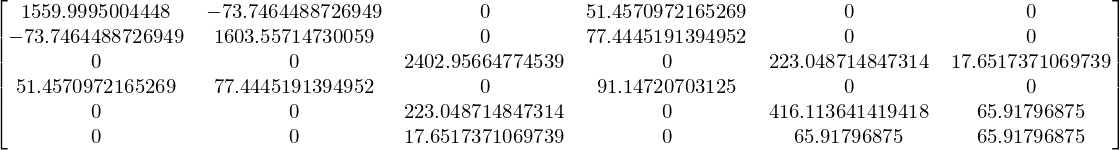

In [6]:
ang_s0 = Array([0., 0., 0.])
q0 = Array([pi / 3 * 0, 5*pi / 4, pi/2])
M_num = dyn.substitute(M, m=m, l=l, I=I, ang_s0=ang_s0, q0=q0)
M_num.evalf()

In [20]:
M_num.shape

In [21]:
C_num = dyn.substitute(C, m=m, l=l, I=I, ang_s0=ang_s0, q0=q0)

In [22]:
C_num

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                  ⎛⎛                                                      2⎞ 
⎢0.353553390593274⋅⎜⎝0.25 + 50.0⋅(0.138106793200498⋅√2 + 0.772259706288418) ⎠⋅
⎢                  ⎝                                                          
⎢                                                   

In [23]:
C_num.shape

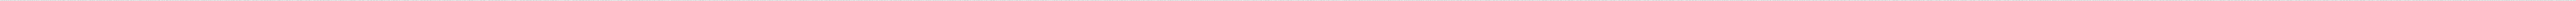

In [24]:
C_num[0]